In [7]:
file_to_company_mapping = {
    "data/2023/QTR1/20230208_10-K_edgar_data_913144_0000913144-23-000011.txt": "RENAISSANCERE HOLDINGS LTD",
    "data/2023/QTR1/20230223_10-K_edgar_data_944695_0000950170-23-004178.txt": "HANOVER INSURANCE GROUP, INC.",
    "data/2023/QTR1/20230331_10-K_edgar_data_33992_0001654954-23-004080.txt": "KINGSTONE COMPANIES, INC.",
    "data/2023/QTR1/20230315_10-K_edgar_data_1412100_0001412100-23-000030.txt": "Maiden Holdings, Ltd.",
    "data/2023/QTR1/20230310_10-K_edgar_data_1400810_0000950170-23-007271.txt": "HCI Group, Inc.",
    "data/2023/QTR1/20230217_10-K_edgar_data_1096343_0001096343-23-000033.txt": "MARKEL CORP",
    "data/2023/QTR1/20230224_10-K_edgar_data_11544_0000011544-23-000004.txt": "BERKLEY W R CORP",
    "data/2023/QTR1/20230223_10-K_edgar_data_20286_0000020286-23-000008.txt": "CINCINNATI FINANCIAL CORP",
    "data/2023/QTR1/20230224_10-K_edgar_data_1669162_0001669162-23-000009.txt": "Kinsale Capital Group, Inc.",
    "data/2023/QTR1/20230207_10-K_edgar_data_60086_0000060086-23-000025.txt": "LOEWS CORP"
}

***TF-IDF estimation***

Extracting Descriptions 10/10...66...[]
Processing complete!                                                   
Total invalid files: 0
Processing complete!                                                   
Computing TF 10/10...10...

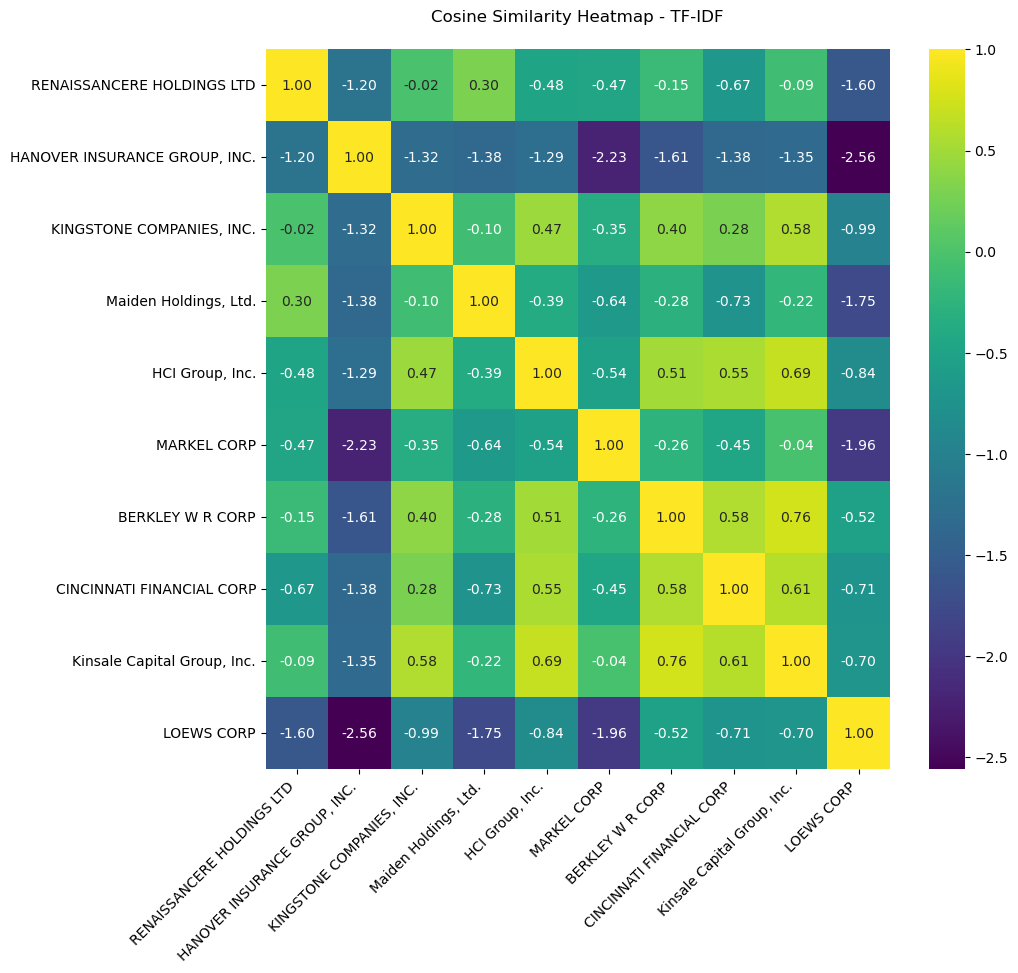

In [30]:
import os
import re
import sys
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import tee
from nltk.corpus import words
from collections import Counter
import matplotlib.pyplot as plt
from pathos.multiprocessing import Pool
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# Important
# Industry selected in line 153
# The least popular tokens are cut in line 233, the rest is automatic.

nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words
nlp.max_length = 1e9
english_vocab = set(words.words())

def update_progress(index, total, message="Processing file"):
    progress = f"{message} {index}/{total}..."
    sys.stdout.write('\r' + progress)
    sys.stdout.flush()

patterns = {
1:  re.compile(
    r"""
    (?i)i[\s]*t[\s]*e[\s]*m[\s]*\s*1[^\w\s]*\s*                  
    b[\s]*u[\s]*s[\s]*i[\s]*n[\s]*e[\s]*s[\s]*s[\s]*             
    .*?                                                          
    i[\s]*t[\s]*e[\s]*m[\s]*\s*1[^\w\s]*\s*                      
    b[\s]*u[\s]*s[\s]*i[\s]*n[\s]*e[\s]*s[\s]*s[\s]*             
    (.*?)                                                        
    i[\s]*t[\s]*e[\s]*m[\s]*\s*2[^\w\s]*\s*                      
    p[\s]*r[\s]*o[\s]*p[\s]*e[\s]*r[\s]*t[\s]*i[\s]*e[\s]*s[\s]* 
    """,
    re.DOTALL | re.VERBOSE),

2:  re.compile(
    r"""
    (?i)                                
    i[\s]*t[\s]*e[\s]*m[\s]*1[\s]*[.,]? 
    (?![\s]*[AaBb\d])                   
    .*?                                 
    i[\s]*t[\s]*e[\s]*m[\s]*1[\s]*[.,]? 
    (?![\s]*[AaBb\d])                    
    (.*?)                               
    (?=i[\s]*t[\s]*e[\s]*m[\s]*\s*(2[^\w\s]*|[3-9]|[1-9][0-9])) 
    """,
    re.DOTALL | re.VERBOSE),

3:  re.compile(
    r"""
    (?i)i[\s]*t[\s]*e[\s]*m[s]?\s*1[\s.,:] 
    (.{10000,}?)                                                        
    (?=i[\s]*t[\s]*e[\s]*m\s*[2-9]|i[\s]*t[\s]*e[\s]*m\s*[1-9]\d)                                    
    """,
    re.DOTALL | re.VERBOSE),

4:  re.compile(
    r"""
    (?i)d[\s]*e[\s]*s[\s]*c[\s]*r[\s]*i[\s]*p[\s]*t[\s]*i[\s]*o[\s]*n[\s]*  
    o[\s]*f[\s]*                                                       
    b[\s]*u[\s]*s[\s]*i[\s]*n[\s]*e[\s]*s[\s]*s?[\s]*             
    (.{10000,}?)                                                        
    (?=item\s*[2-9]|item\s*[1-9]\d)  
    """,
    re.DOTALL | re.VERBOSE)
}

def process_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
            text = re.sub(r'[^\S ]', '', text)
            text = re.sub(r'\s+', ' ', text)
            for current_pattern in patterns.values():
                match = current_pattern.search(text)
                if match:
                    matched_text = match.group(1).strip()
                    if len(matched_text) >= 2000:  # Valid match
                        return (file_path, matched_text, None)

            return (file_path, None, "Invalid")
    except Exception as e:
        return (file_path, None, f"Error: {e}")

def process_text(file_path):
    path, text = file_path # TODO: Read the file
    doc = nlp(text)
    filtered_tokens = [
    token.text.lower()
    for token in doc
    if token.is_alpha and not token.is_stop and token.text.lower() in english_vocab]
    return (path, filtered_tokens)

def get_vocab(tokens):
    return Counter(tokens)

def get_tf(path_tokens_allowed):
    path, tokens, allowed = path_tokens_allowed
    counter = Counter(token for token in tokens)
    tf_values = [counter.get(token, 0) for token in allowed]
    return (path, tf_values)

if __name__ == '__main__':
    
    #-------------Classifications----------------#
    base_directory = "data/2023"
    root = os.getcwd()
    path = os.path.join(root, base_directory)

    unique_lines = set()
    invalid_counter = 0

    paths, idx = tee((os.path.join(root_dir, file)
                    for root_dir, _, files in os.walk(path)
                    for file in files if not file.startswith('.')))

    frame_dict = defaultdict(list)
    total_files = len(list(idx))
    for idx, file_path in enumerate(paths, 1):
        update_progress(idx, total_files, "Fetching Classifications")
        with open(file_path, 'r', encoding='utf-8') as f:
            for _ in range(26):
                f.readline()
            line = f.readline().strip()
            if line.startswith("STANDARD INDUSTRIAL CLASSIFICATION:"):
                clean_line = line.split("\t")[1].strip()
                unique_lines.add(clean_line)
                frame_dict[clean_line].append(os.path.relpath(file_path, root))
            else:
                invalid_counter += 1

                    
    rows = ({"SIC": sic, "File": file} 
            for sic, files in frame_dict.items() 
            for file in files)
    replace_str = {'[3949]': 'SPORTING & ATHLETIC GOODS, NEC [3949]',
                '[6221]': 'COMMODITY CONTRACTS BROKERS & DEALERS [6221]'}

    df = pd.DataFrame(rows).apply(lambda x: x.replace(replace_str), axis=1).sort_values(by='SIC')
    # df.to_csv('data/data_2023.csv', index=False)
    # print(df)

    #---------------Descriptions-----------------#
    # input_industry = 'SEARCH, DETECTION, NAVIGATION, GUIDANCE, AERONAUTICAL SYS [3812]'
    input_industry = 'FIRE, MARINE & CASUALTY INSURANCE [6331]'
    # input_industry = 'AGRICULTURE CHEMICALS [2870]'
    df = df.loc[df['SIC'] == input_industry, slice(None)].set_index('File').head(10) # First 10 files
    paths = df.index.tolist()
    total_files = len(paths)
    invalid_files = []

    with Pool() as pool:
        results = []
        for idx, result in enumerate(pool.imap(process_file, paths), 1):
            update_progress(idx, total_files, 'Extracting Descriptions')
            results.append(result)

    for file_path, matched_text, error in results:
        if matched_text:
            df.at[file_path, 'Text'] = matched_text
        elif error:
            invalid_files.append(file_path)

    print(invalid_files)
    if not len(invalid_files) == 0:
        with open('invalid_files.txt', 'w') as f:
            f.write('This file contains the list of unmatched or imporoperly matched files.\n')
            for file in set(invalid_files):
                f.write(file + '\n')

    sys.stdout.write('\rProcessing complete! ' + ' ' * 50 + '\n')

    df = df.reset_index().dropna()
    # df.to_csv('data/reduced_data_2023.csv', index=False)
    print(f"Total invalid files: {len(set(invalid_files))}")
    # print(df)

    #---------------Lemmatization-----------------#
    # ATTENTION! This operation is extremely slow and may take hours to complete
    # if executed on the entire dataset. It is best to use a subset of the data.
    # The output of a full execution is available in data/cleaned_data_2023.csv.

    texts = df['Text'].tolist()
    df.drop('Text', axis=1, inplace=True)
    total_files = len(texts)
    texts = [(path, text) for path, text in zip(df.index.to_list(), texts)]
    df['Tokens'] = [[] for _ in range(len(df))]

    with Pool() as pool:
        results = []
        for idx, result in enumerate(pool.imap(process_text, texts), 1):
            update_progress(idx, total_files, 'Lemmatizing Text')
            results.append(result)

    for path, tokens in results:
        try:
            df.at[path, 'Tokens'] = tokens
        except Exception as e:
            print(e)

    sys.stdout.write('\rProcessing complete! ' + ' ' * 50 + '\n')

    df = df.reset_index().dropna()
    # df.to_csv('data/reduced_subset_tokens_2023.csv', index=False)
    # print(df)

    #---------------TF-IDF-----------------#
    path_list = df['File'].to_list()
    token_list = df['Tokens'].to_list()
    with Pool() as pool:
        results = []
        token_counts = Counter()
        for idx, token_counter in enumerate(pool.imap(get_vocab, token_list), 1):
            update_progress(idx, total_files, 'Processing tokens')
            results.append(token_counter)
        
    for token_counter in results:
        token_counts.update(token_counter)

    filtered_token_counts = {token: count for token, count in token_counts.items()}
    token_counts_df = pd.DataFrame(filtered_token_counts.items(), columns=['Token', 'Count']).sort_values('Count', ascending=False)
    #--FOR WORD CLOUD--
    token_counts_df['Token'] = token_counts_df['Token'].apply(lambda token: np.nan if len(token) == 1 else token).dropna()
    token_counts_df.dropna(inplace=True)
    #------------------
    token_counts_df.to_csv('data/token_counts.csv', index=False)

    # print("\nMost common valid English tokens:")
    # print(token_counts_df.head(10))

    allowed_tokens = sorted(set(token_counts_df[token_counts_df['Count'] >= 10]['Token']))

    with Pool() as pool:
        results = []
        args = ((path, tokens, allowed_tokens) for path, tokens in zip(path_list, token_list))
        for idx, (path, tf_values) in enumerate(pool.imap(get_tf, args), 1):
            update_progress(idx, total_files, 'Computing TF')
            results.append((path, tf_values))

    tf_matrix = np.array([tf_values for _, tf_values in results])
    idf_array = np.log1p(total_files) - np.log1p(token_counts_df.set_index('Token').loc[allowed_tokens]['Count'].values) 
    tfidf_matrix = tf_matrix * idf_array

    tfidf_df = pd.DataFrame(
        data=tfidf_matrix,
        index=[path for path, _ in results],
        columns=allowed_tokens
    ).reset_index()
    tfidf_df.rename(columns={'index': 'File'}, inplace=True)

    # COSINE SIMILARITY
    tfidf_matrix_normalized = tfidf_matrix / np.linalg.norm(tfidf_matrix, axis=1, keepdims=True)

    cosine_sim = cosine_similarity(tfidf_matrix_normalized)
    cosine_sim_df = pd.DataFrame(
        cosine_sim,
        index=[path for path, _ in results],
        columns=[path for path, _ in results]
    )

    cosine_sim_df.to_csv('cosine_similarity.csv', index=True)
    cosine_sim_df.rename(columns=file_to_company_mapping, index=file_to_company_mapping, inplace=True)
    # normalize so that max is 1 and min is 0.86030
    cosine_sim_df = (cosine_sim_df - 0.86030) / (1 - 0.86030)

    fig, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(
        cosine_sim_df,
        cmap="viridis",
        annot=True,
        fmt=".2f",
        cbar=True,
        ax=ax)
    
    ax.set_title("Cosine Similarity Heatmap - TF-IDF", pad=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.3)
    plt.show()

***Embedding Estimation***

Generating embeddings for all 10 texts...
Generating embeddings for chunk: 2/2 [Text: 10/10]
Embeddings saved to embeddings_output.csv
Calculating cosine similarity matrix...


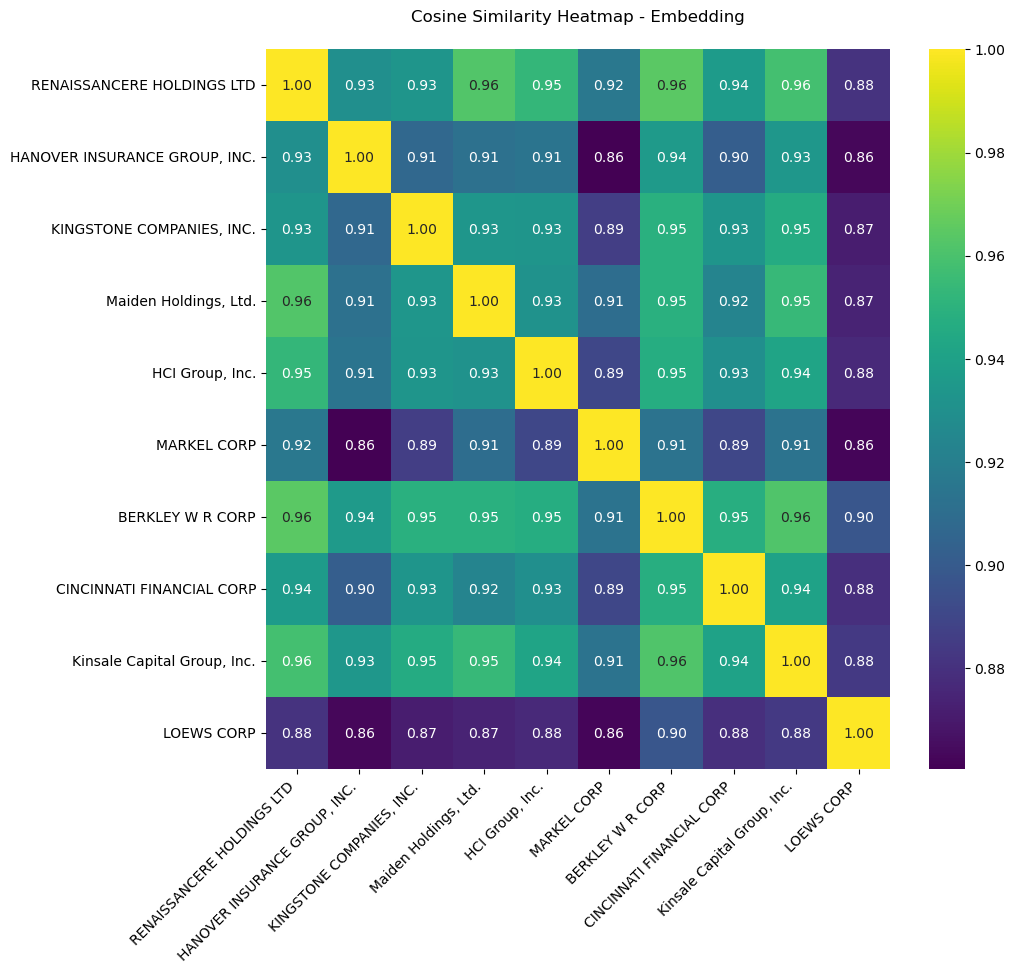

In [9]:
import openai
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import tiktoken
import ssl
import matplotlib.pyplot as plt
import seaborn as sns

# Set your OpenAI API key
openai.api_key = "APIKEY"

df = pd.read_csv("data/updated_data_2023.csv")

def get_text_and_files_by_industry(input_industry):
    filtered_data = df[df['SIC'] == input_industry]
    if filtered_data.empty:
        raise ValueError("No files found for the given industry.")
    if len(filtered_data) < 10:
        raise ValueError("Less than 10 files found for the given industry.")
    return filtered_data.head(10)

def split_text_by_tokens(text, max_tokens=8192, model="text-embedding-ada-002"):
    tokenizer = tiktoken.encoding_for_model(model)
    tokens = tokenizer.encode(text)
    chunks = []
    
    # Split tokens into chunks
    for i in range(0, len(tokens), max_tokens):
        chunk_tokens = tokens[i:i + max_tokens]
        chunk_text = tokenizer.decode(chunk_tokens)
        if chunk_text.strip():  # Ensure chunk is not empty
            chunks.append(chunk_text)
    
    return chunks

def generate_embedding(text):
    try:
        response = openai.embeddings.create(
            input=text,
            model="text-embedding-ada-002"
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"Error generating embedding: {e}")
        return None  # Return None on failure

def combine_embeddings(embeddings):
    valid_embeddings = [e for e in embeddings if e is not None]
    if not valid_embeddings:
        raise ValueError("No valid embeddings to combine.")
    return np.nanmean(valid_embeddings, axis=0).tolist()

# Process a single large text
def process_large_text(text, idx):
    # Step 1: Split the text into chunks
    chunks = split_text_by_tokens(text, max_tokens=8191)  # Reserve 1 token for safety
    sys.stdout.flush()
    sys.stdout.write(f'\rSplit text {idx+1} into {len(chunks)} chunks."')

    # Step 2: Generate embeddings for each chunk
    chunk_embeddings = []
    for i, chunk in enumerate(chunks):
        string = f'Generating embeddings for chunk: {i+1}/{len(chunks)} [Text: {idx+1}/10]'
        sys.stdout.write(f'\r{string}')
        chunk_embedding = generate_embedding(chunk)
        if chunk_embedding is not None:
            chunk_embeddings.append(chunk_embedding)
    
    # Step 3: Combine chunk embeddings
    if not chunk_embeddings:
        raise ValueError("No valid embeddings were generated.")
    final_embedding = combine_embeddings(chunk_embeddings)
    return final_embedding

def generate_embeddings_for_texts(text_list):
    embeddings = []
    for idx, text in enumerate(text_list):
        embedding = process_large_text(text, idx)
        embeddings.append(embedding)
    return embeddings

def compute_cosine_similarity(embeddings):
    embedding_matrix = np.array(embeddings)
    similarity_matrix = cosine_similarity(embedding_matrix)
    return similarity_matrix



def save_embeddings_to_csv(embeddings, labels, output_csv_path):
    data = {"File": labels,
            "Embedding": [",".join(map(str, embedding)) for embedding in embeddings]}
    df_embeddings = pd.DataFrame(data)
    
    df_embeddings.to_csv(output_csv_path, index=False)
    print(f"\nEmbeddings saved to {output_csv_path}")

if __name__ == "__main__":
    try:
        # Get 10 texts and file names for a specific industry
        # select the indusry you want to compare (> 10 companies)
        input_industry = 'FIRE, MARINE & CASUALTY INSURANCE [6331]'
        df = get_text_and_files_by_industry(input_industry)
        output_text_list, firm_labels = df['Text'].tolist(), df['File'].tolist()
        
        # Generate embeddings for all 10 texts
        print("Generating embeddings for all 10 texts...")
        embeddings = generate_embeddings_for_texts(output_text_list)

        output_csv_path = "embeddings_output.csv"
        save_embeddings_to_csv(embeddings, firm_labels, output_csv_path)

        # Calculate cosine similarity
        print("Calculating cosine similarity matrix...")
        similarity_matrix = compute_cosine_similarity(embeddings)
        fig, ax = plt.subplots(figsize=(12, 12))
        sns.heatmap(
            similarity_matrix,
            xticklabels=file_to_company_mapping.values(),
            yticklabels=file_to_company_mapping.values(),
            cmap="viridis",
            annot=True,
            fmt=".2f",
            cbar=True,
            ax=ax)
        
        ax.set_title("Cosine Similarity Heatmap - Embedding", pad=20)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        
        plt.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0.3)
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")



***Word Cloud graph***

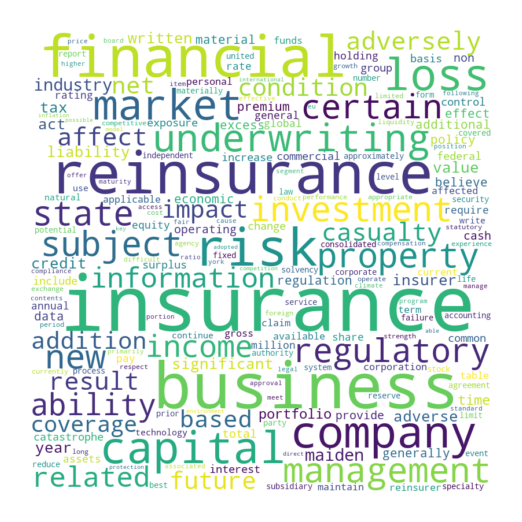

Total tokens: 3534
Removed 2497 tokens with frequency less than 10.
Remaining tokens: 1037


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud

df = pd.read_csv('data/token_counts.csv')
df = df.sort_values('Count', ascending=False)

wc = WordCloud(
    width=800, 
    height=800, 
    background_color='white',
    prefer_horizontal=1.0
).generate_from_frequencies(dict(zip(df['Token'], df['Count'])))

plt.figure(figsize=(4, 2), dpi=300)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

removed_tokens = df[df['Count'] < 10]['Token'].tolist()
print(f"Total tokens: {len(df)}")
print(f"Removed {len(removed_tokens)} tokens with frequency less than 10.")
print(f"Remaining tokens: {len(df) - len(removed_tokens)}")